In [9]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import h5py
import hdf5plugin

data_path = "/home/panda/rf_data/dataset/raw"
img_path = "/home/panda/rf_data/dataset/img"

dl = DataLoader("/home/panda/rf_data/")

nz = 2048
nx = 256
new_Ns = 2800


device = "cuda"
dtype = torch.float32

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df = dl.get_df()
df = df.query("RF == 1 and n_channels == 128 and source == 'CUBDL'")
df = df[df["name"].str[:3] != "JHU"]

names = df["name"]

In [11]:
from deep_bf.wrapper import BenchmarkWrapper

beamformer = "MVB"
bfs = [beamformer]

pbar = tqdm(names)

from pathlib import Path

for name in pbar:
    pbar.set_description(f"Procesando archivo: {name}°")

    path = Path(f"{data_path}/{name}.hdf5")
    if path.exists():
        continue

    pw = dl.get_defined_pwdata(name, "RF")

    if pw.n_samples <= new_Ns:
        pw.data = np.pad(pw.data, pad_width=((0,0), (0,0), (0, new_Ns - pw.n_samples)), mode='constant', constant_values=0)
    else:
        pw.data = pw.data[:, :, :new_Ns]
        pw.img_depth = (new_Ns / pw.fs) * (pw.c0 / 2)
    pw.n_samples = new_Ns

    f_num = 1.75
    window = "tukey25"

    angles_idx = np.arange(pw.n_angles)

    bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bfs, f_num, window, device=device, dtype=dtype)
    o = bw.compute_reconstructions()[bfs[0]]

    angle = pw.n_angles // 2
    #samples_idx = bw.get_samples_idx_by_angle(angle)

    rf_name = f"{pw.name}$rf"
    samples_idx_name = f"{pw.name}$samples_idx"
    ground_truth_name = f"{pw.name}$ground_truth"

    _rf = pw.data[angle]
    #_samples_idx = samples_idx.cpu()
    _data = o.data.mean(axis=0).cpu()
    #_data = o.data.cpu()

    #np.save(f"{data_path}/{rf_name}.npy", pw.data)
    #np.save(f"{data_path}/{samples_idx_name}.npy", _samples_idx)
    #np.save(f"{data_path}/{ground_truth_name}.npy", _data)

    #np.savez_compressed(f"{data_path}/{name}.npz", rf=pw.data, samples_idx=_samples_idx, ground_truth=_data)

    with h5py.File(f"{data_path}/{name}.hdf5", "w") as f:
        f.create_dataset("rf", data=_rf, chunks=True, **hdf5plugin.Bitshuffle(nelems=0, cname="zstd"))
        #f.create_dataset("samples_idx", data=_samples_idx, chunks=True, **hdf5plugin.Bitshuffle(nelems=0, cname="zstd"))
        f.create_dataset("ground_truth", data=_data, chunks=True, **hdf5plugin.Bitshuffle(nelems=0, cname="zstd"))

Procesando archivo: UFL001°:   0%|          | 0/544 [00:00<?, ?it/s]

Procesando archivo: TSH501°: 100%|██████████| 544/544 [00:00<00:00, 3278.69it/s]


In [ ]:
from deep_bf.wrapper import BenchmarkWrapper

beamformer = "MVB"
bfs = [beamformer]

pw = dl.get_defined_pwdata(name, "RF")

if pw.n_samples <= new_Ns:
    pw.rfdata = np.pad(pw.data, pad_width=((0,0), (0,0), (0, new_Ns - pw.n_samples)), mode='constant', constant_values=0)
else:
    pw.rfdata = pw.data[:, :, :new_Ns]
    pw.img_depth = (new_Ns / pw.fs) * (pw.c0 / 2)
pw.n_samples = new_Ns

angles_idx = np.arange(pw.n_angles)

f_num = 1.75
window = "tukey25"

bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bfs, f_num, window, device=device, dtype=dtype)
o = bw.compute_reconstructions()[bfs[0]]

In [52]:
angle = pw.n_angles // 2
sample_idx = bw.get_samples_idx_by_angle(angle)

print(pw.name)

OSL007


In [44]:
from deep_bf.wrapper import Reconstruction
from deep_bf.beamformers import compute_meshgrid

data = sample_idx.sum(axis=0)
Z, X = compute_meshgrid(pw, nz, nx)

o = Reconstruction(data, Z, X, metadata=None)

In [22]:
from deep_bf.wrapper import BenchmarkWrapper

#name = "TSH193"
#name = "MYO002"
name = "OSL007"
#name = "carotid_cross_expe_dataset_rf"
#bfname = "DASGridSample"
bfname = "DASManual"
#bfname = "FDMAS"
#bfname = "MVB"
bf_names = [bfname]

pw = dl.get_defined_pwdata(name, "RF")
angles_idx = np.arange(pw.n_angles)

f_num = 1.75
window = "tukey25"

bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
o = bw.compute_reconstructions()[bfname]

In [25]:
print(o.get_bmode())

torch.Size([75, 2048, 256])
[[-31.283699 -36.55594  -33.802914 ... -19.182274 -21.166824 -25.67897 ]
 [-29.829357 -31.120113 -29.448112 ... -18.242104 -19.234238 -19.835808]
 [-29.152359 -28.454147 -27.962006 ... -18.149708 -19.338192 -18.903141]
 ...
 [-47.968864 -41.10994  -40.907333 ... -33.192604 -47.220123 -38.44966 ]
 [-44.027046 -45.321648 -40.56652  ... -39.16483  -33.694324 -33.586533]
 [-36.977795 -49.528885 -37.77956  ... -25.533142 -26.943344 -36.254036]]


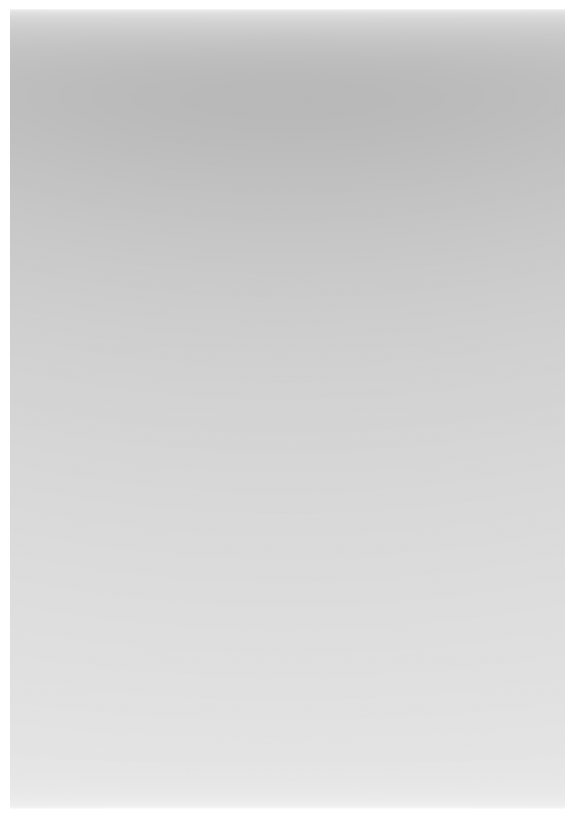

In [ ]:
import matplotlib.pyplot as plt

vmin = -60
vmax = 0

fig = plt.figure(figsize=(6, 8), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = o.get_bmode(vmin=0, vmax=-60, single_angle=False)
extent = (o.xlims[0], o.xlims[-1], o.zlims[-1], o.zlims[0])


ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()

In [13]:
print(data[0][1])

tensor([ 4.2110e+00, -1.0577e+01, -3.6390e+00,  1.6316e+01, -2.4686e+01,
         1.2827e+01, -2.2903e+00,  1.5791e+01, -1.3388e+01,  5.6585e+00,
         4.6608e-02, -9.1119e+00,  9.8148e+00, -1.6625e+01,  3.8236e+00,
        -4.1594e+00,  9.0273e+00, -1.8837e+01,  2.0557e+01, -4.2917e+00,
        -9.1100e+00,  3.0717e+00, -1.1077e+01,  1.1440e+01, -5.0812e+00,
         5.7382e+00, -1.9731e+01,  1.2625e+01,  9.0729e+00, -9.5673e+00,
        -3.5608e+00,  1.2547e+01, -1.6833e+01,  9.5180e+00,  1.0289e+01,
         5.9094e+00, -4.9924e+00, -1.1385e+00, -1.9380e+01,  6.8770e+00,
         2.2687e+01, -2.3120e+01,  3.5303e+00,  1.4306e+01, -9.0821e+00,
         1.5819e+00, -9.8546e-01,  9.4614e-01,  2.4512e+01, -2.4471e+01,
         1.2255e+01, -1.4867e+01,  4.1944e+00,  9.6028e-01,  3.5720e+00,
        -6.0358e+00, -3.6427e+01,  2.2665e+01, -1.2017e+01, -1.5581e+01,
         1.2389e+01, -2.5976e+00,  3.0665e+00,  5.1062e+00, -1.9151e+01,
        -1.0096e+01,  1.4728e+01,  5.0473e+00, -1.8

(2048, 256)


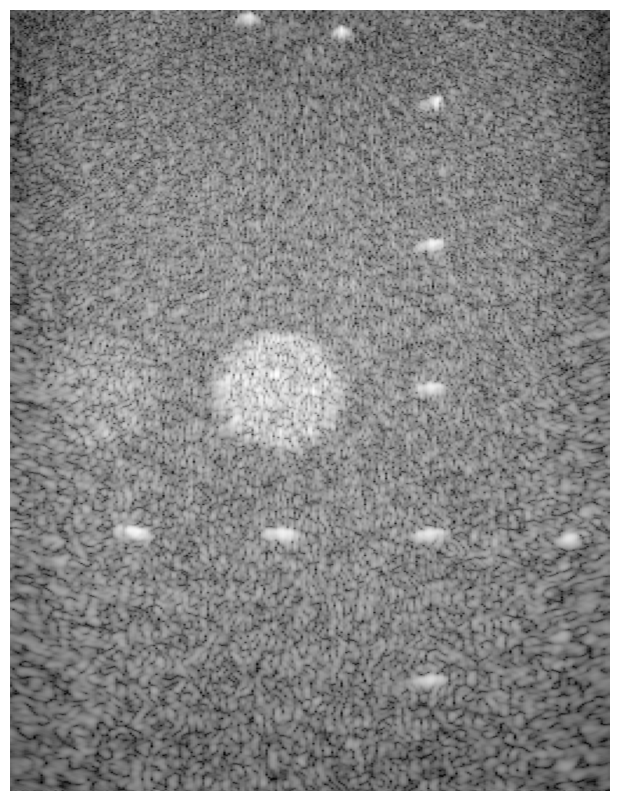

In [28]:
import matplotlib.pyplot as plt
from deep_bf.beamformers import compute_meshgrid, get_rf_bmode
from deep_bf.wrapper import Reconstruction

_name = "MYO002"
pw = dl.get_defined_pwdata(_name, "RF")
data = np.load("/home/panda/rf_data/dataset/raw/MYO002$ground_truth.npy")
print(data.shape)
Z, X = compute_meshgrid(pw, nz, nx)

Z = Z.cpu()
X = X.cpu()

zlims = np.array([Z[0, 0], Z[-1, 0]]) * 1e3
xlims = np.array([X[0, 0], X[0, -1]]) * 1e3

vmin = -60
vmax = 0

fig = plt.figure(figsize=(6, 8), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = get_rf_bmode(data, vmin, vmax)
extent = (xlims[0], xlims[-1], zlims[-1], zlims[0])

ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()

In [83]:
import h5py

with h5py.File("/home/panda/rf_data/dl_data/carotid_cross_expe_dataset_rf.hdf5", "r") as f:
    print(list(f.keys()))
    rf = f["rfdata"][:]
    grid = f["grid"][:]
    probe = f["probe_geometry"][:]
    img = f["img"][:]

    print(rf.shape)
    print(grid.shape)
    print(probe.shape)
    print(img.shape)

['grid', 'img', 'probe_geometry', 'rfdata']
(128, 2800)
(2048, 256, 3)
(128, 3)
(2048, 256)


In [8]:
import h5py

#_name = "MYO002"
#_name = "carotid_cross_expe_dataset_rf"
#_name = "carotid_long_expe_dataset_rf"
_name = "TSH345"

pw = dl.get_defined_pwdata(_name, "RF")

with h5py.File(f"/home/panda/rf_data/dataset/raw/{_name}.hdf5", "r") as f:
    print(list(f.keys()))
    rf = f["rf"][:]
    samples_idx = f["samples_idx"][:]
    ground_truth = f["ground_truth"][:]

    samples_idx2 = samples_idx.astype(np.bfloat16)
    samples_idx3 = np.round(samples_idx).astype(np.uint16)
    samples_idx4 = samples_idx.astype(np.float16)

    print(rf.shape)
    print(samples_idx.shape)
    print(ground_truth.shape)

s = np.array([samples_idx, samples_idx2, samples_idx3, samples_idx4])

['ground_truth', 'rf', 'samples_idx']


AttributeError: module 'numpy' has no attribute 'bfloat16'

In [5]:
type(s[0].dtype)

numpy.dtypes.Float32DType

In [6]:
import torch.nn.functional as F

norm_factor = 2.0 / (2800 - 1)

_rf = torch.from_numpy(rf).to(device=device, dtype=dtype)
_samples_idx = torch.from_numpy(samples_idx).to(device=device, dtype=dtype)

_rf = _rf.reshape(128, 1, 1, 2800)
grid = torch.zeros(128, nz, nx, 2, device=device, dtype=dtype)

bf = []
for _s in s:
    _s = torch.from_numpy(_s).to(device=device, dtype=dtype)
    
    grid[..., 0] = _s * norm_factor - 1.0

    selected_samples =  F.grid_sample(
        _rf,
        grid,
        mode="bilinear",
        padding_mode="zeros",
        align_corners=True,
    )

    selected_samples = selected_samples.view(128, nz, nx)

    bf.append(selected_samples.sum(dim=0).cpu())


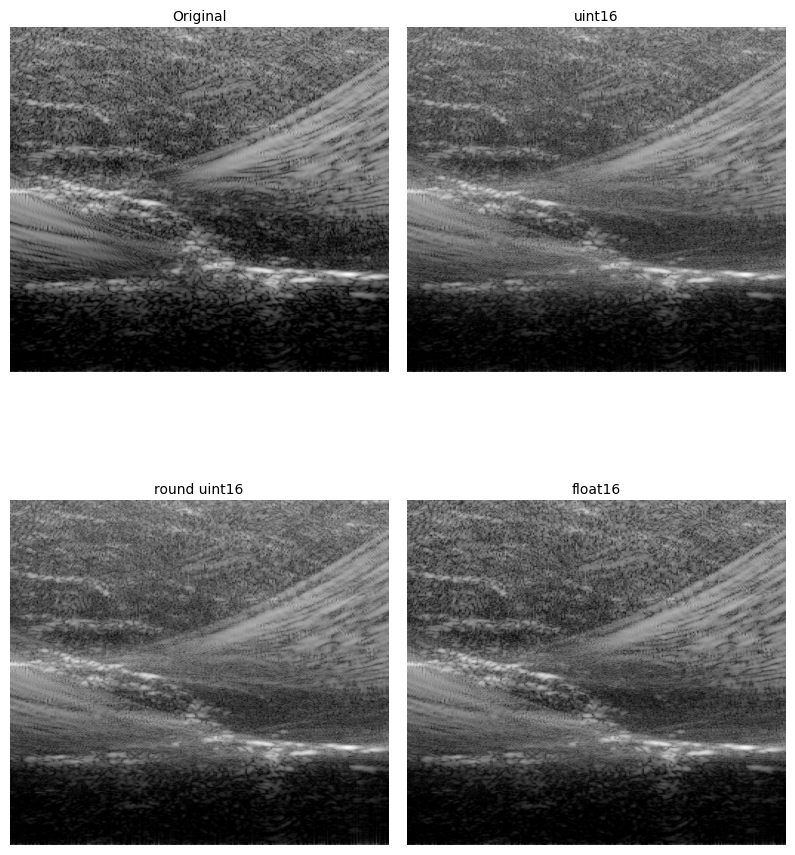

In [7]:
import matplotlib.pyplot as plt
from deep_bf.beamformers import compute_meshgrid, get_rf_bmode

bmodes = [get_rf_bmode(_bf) for _bf in bf]

Z, X = compute_meshgrid(pw, nz, nx)

Z = Z.cpu()
X = X.cpu()

zlims = np.array([Z[0, 0], Z[-1, 0]]) * 1e3
xlims = np.array([X[0, 0], X[0, -1]]) * 1e3

vmin = -60
vmax = 0

fig, axes = plt.subplots(2, 2, figsize=(10, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05) # Espacio mínimo entre imágenes

extent = (xlims[0], xlims[-1], zlims[-1], zlims[0])
titulos = ["Original", "uint16", "round uint16", "float16"] # Opcional

# Aplanamos la matriz de ejes para iterar fácilmente
for i, ax in enumerate(axes.flat):
    if i < len(bmodes):
        im = ax.imshow(bmodes[i], cmap='gray', 
                       vmin=vmin, vmax=vmax,
                       extent=extent, 
                       aspect='equal')
        
        # Opcional: poner título dentro o fuera
        ax.set_title(titulos[i], fontsize=10, pad=5)
        ax.set_axis_off()

# Opcional: añadir una barra de color lateral común
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(im, cax=cbar_ax, label='dB')

plt.show()

In [80]:
from pathlib import Path

data_path = "/home/panda/rf_data/dataset/raw"
path = Path(data_path)

files = list(path.glob("*.hdf5"))
files = [f for f in path.iterdir() if f.is_file()]


In [82]:
for file in files:
    with h5py.File(file, 'r+') as f:
        if "samples_idx" in f:
            data = f["samples_idx"][:]
            _data = data.astype(np.float16)
            del f["samples_idx"]
            f.create_dataset(
                "samples_idx", 
                data=_data, 
                chunks=True, 
                **hdf5plugin.Bitshuffle(nelems=0, cname="zstd")
            )

KeyboardInterrupt: 

In [20]:
print(df['source'].unique())

['CUBDL' 'PICMUS']


In [27]:

df2 = df.sort_values("name")
df2 = df2.query("RF == 1 and n_channels == 128 and source == 'CUBDL'")

keys = ["n_angles", "sampling_frecuency", "aperture_width", "element_width", "pitch", "image_depth", "n_channels", "zlims", "center_frecuency"]
group = df2.groupby(keys)


for group_name, mini_df in group:
    gn = mini_df["name"]
    print(gn.iloc[0], gn.iloc[-1], gn.count())

TSH002 TSH501 500
JHU024 JHU030 5
OSL010 OSL010 1
INS001 INS013 13
OSL002 OSL002 1
OSL003 OSL003 1
OSL004 OSL004 1
OSL005 OSL005 1
OSL006 OSL006 1
OSL007 OSL007 1
MYO001 MYO006 6
INS014 INS026 13
JHU028 JHU032 4
JHU033 JHU034 2
UFL001 UFL005 5


In [11]:
group
